# Automatic Detection of Coronavirus Disease in X-ray Images

## Import Packages

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.applications.vgg16 import VGG16

import import_ipynb
import util

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping

importing Jupyter notebook from util.ipynb


## Load datasets

In [2]:
train_df = pd.read_csv("Dataset/train.csv", dtype =str)
valid_df = pd.read_csv("Dataset/valid.csv", dtype =str)
test_df = pd.read_csv("Dataset/test.csv", dtype =str)

train_df.head()

,PatientID,Image,Covid_19
0,40,134.jpg,1
1,41,135.jpg,0
2,42,136.jpg,1
3,43,137.jpg,0
4,44,138.jpg,1


In [3]:
labels = ['Covid_19']

## Preventing Data Leakage
In the case that a patient has multiple X-ray images at the different time during their hospital visits. In our data splitting, we have ensured that split is done on the patient level so that there is no data "leakage" between the train, validation and the test datasets.

In [4]:
def check_for_leakage(df1, df2, patient_id):
    df1_patients_unique = set(df1[patient_id].values)
    df2_patients_unique = set(df2[patient_id].values)
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))
    
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = True if len(patients_in_both_groups) > 0 else False
    return leakage

In [5]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientID')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientID')))

leakage between train and test: False
leakage between valid and test: False


We get False for both, then we’re ready to start preparing the datasets for training.

## Preparing Images
- Using ImageDataGenerator class from Keras Framwork, which allows to build a gennerator for images in a dataframe
- This class also support for basic data augmentation
- Using the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1. This will facilitate model by standardizing the input distribution

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle = True, batch_size=8, seed = 1, target_w = 224, target_h = 224):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
      class_mode: "raw": numpy array of values in y_col column(s)
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator....")
    # using standard image normalization techniques to improve the quality of visual information of the input data.
    # The statistics can also be calculated then used to standardize each image separately, and Keras refers to this as sample-wise standardization.
    image_generator = ImageDataGenerator(
        samplewise_center = True,
        samplewise_std_normalization = True,
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect'
    )
    
    # flow from dataframe with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
        dataframe = df,
        directory = image_dir,
        x_col = x_col,
        y_col = y_cols,
        class_mode="binary",
        batch_size = batch_size,
        shuffle = shuffle,
        seed = seed,
        target_size = (target_w, target_h)
    )
    
    return generator

### Build a separate generator for valid and test sets
Normalizing incoming test data using the statistics computed from the training set. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. However, since this is extremely large, that would be very time consuming. In the interest of time, we’ll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [7]:
def get_valid_and_test_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size = 100, batch_size = 8, seed = 1, target_w = 224, target_h = 224):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image", 
        y_col=y_cols, 
        class_mode="binary",
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]
    
    # use sample to fit mean and std for test set generator
    # The mean and standard deviation statistics can be calculated on the training dataset, Keras refers to this as feature-wise.
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
     # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory="D:\Dataset\Dataset\Test",
            x_col=x_col,
            y_col=y_cols,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and validation datasets.

In [8]:
IMAGE_DIR = "D:\Dataset\Dataset\Train"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels[0])

valid_generator, test_generator = get_valid_and_test_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image",  labels[0])

getting train generator....
Found 260 validated image filenames belonging to 2 classes.
getting train and valid generators...
Found 260 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


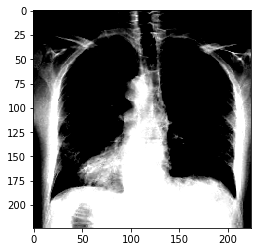

In [9]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

# Model Development
## Addressing Class Imbalance

One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.
Problems with Imbalance Data: 
- While the model training it leads to the model to bias over the minority class, meaning, Our model will learn the features of our majority class very well and fail to capture the features of our minority class.
- Accuracy score can be misleading.

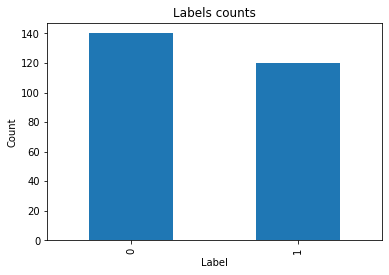

In [10]:
train_df.Covid_19.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

One of the simplest ways to address the class imbalance is to simply provide a weight for each class which places more emphasis on the minority classes such that the end result is a classifier which can learn equally from all classes.

In [11]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

D:\Jupyter\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
print(class_weights)

{0: 0.9285714285714286, 1: 1.0833333333333333}


### DenseNet121
Next, we will use a pre-trained DenseNet121 model which we can load directly from Keras and then add two layers on top of it: 
1. A GlobalAveragePooling2D layer to get the average ofthe last convolution layers from DenseNet121. 
2. A Dense layer with sigmoid activation to get the prediction logits for each of our classes.


In [13]:
# Load a DenseNet121 model without the top layer which consists of fully connected layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Do not train existing weights, they already derive from 'imagenet'
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

A loss function measures the compatibility between output predictions of the network through forward propagation and given ground truth labels.Commonly used loss function for multiclass classification is cross entropy

In [14]:
# Configure the model for training
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

## Training
Training a network is a process of finding kernels in convolution layers and weights in fully connected layers which minimize differences between output predictions and given ground truth labels on a training dataset. A model performance under particular kernels and weights is calculated by a loss function on a training dataset, and learnable parameters, namely kernels and weights, are updated according to the loss value through an optimization algorithm.

With model ready for training, We will use the model.fit() functions in Keras to train our model.

In [16]:
# early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [17]:
# Train a model
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(valid_generator), 
                              epochs = 20,
                              callbacks=[es],
                              class_weight=class_weights)
"""
- steps_per_epoch : it specifies the total number of steps taken from the generator
 as soon as one epoch is finished and next epoch has started. We can calculate the value
of steps_per_epoch as the total number of samples in your dataset divided by the batch size.
- validation_steps :only if the validation_data is a generator then only this argument
can be used. It specifies the total number of steps taken from the generator before it is 
stopped at every epoch and its value is calculated as the total number of validation data points
in your dataset divided by the validation batch size.
- Epochs : The number of epochs is the number of complete passes through the training dataset.
"""


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
33/33 [==============================] - 35s 1s/step - loss: 0.4244 - accuracy: 0.8423 - val_loss: 0.2308 - val_accuracy: 0.9500
Epoch 2/20
33/33 [==============================] - 27s 814ms/step - loss: 0.1720 - accuracy: 0.9885 - val_loss: 0.1331 - val_accuracy: 0.9750
Epoch 3/20
33/33 [==============================] - 26s 782ms/step - loss: 0.1065 - accuracy: 0.9923 - val_loss: 0.0844 - val_accuracy: 1.0000
Epoch 4/20
33/33 [==============================] - 26s 793ms/step - loss: 0.0748 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 1.0000
Epoch 5/20
33/33 [==============================] - 30s 899ms/step - loss: 0.0609 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 1.0000
Epoch 6/20
33/33 [==============================] - 26s 778ms/step - loss: 0.0504 - accuracy: 0.9962 - val_loss: 0.0481 - val_accuracy: 1.0000
Epoch 7/20
33/33 [==============================] - 27s 813ms/step - 

'\n- steps_per_epoch : it specifies the total number of steps taken from the generator\n as soon as one epoch is finished and next epoch has started. We can calculate the value\nof steps_per_epoch as the total number of samples in your dataset divided by the batch size.\n- validation_steps :only if the validation_data is a generator then only this argument\ncan be used. It specifies the total number of steps taken from the generator before it is \nstopped at every epoch and its value is calculated as the total number of validation data points\nin your dataset divided by the validation batch size.\n- Epochs : The number of epochs is the number of complete passes through the training dataset.\n'

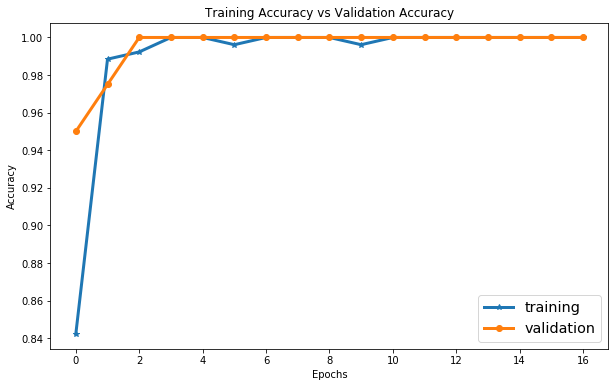

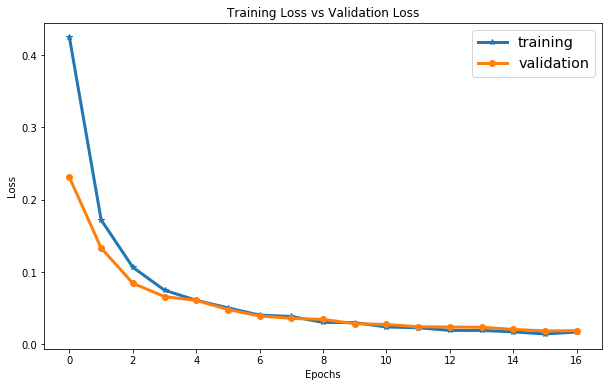

In [18]:
util.visualize_training(history)

## Evaluation

In [19]:
loss, acc = model.evaluate_generator(test_generator,
                                     steps= len(test_generator),
                                     verbose=1)
print('loss: ', loss, 'accuracy: ', acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
10/10 [==============================] - 7s 716ms/step - loss: 0.0135 - accuracy: 1.0000
loss:  0.01354566402733326 accuracy:  1.0


## Prediction

In [20]:
test_generator.reset()
pred = model.predict_generator(test_generator, len(test_generator))
y_pred = []
threshold = 0.5
for i in pred:
    if i >= threshold:
        y_pred.append(1)
    else:  y_pred.append(0)
        

Instructions for updating:
Please use Model.predict, which supports generators.


In [21]:
test_generator.reset()

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



Confusion matrix, without normalization
[[40  0]
 [ 0 40]]


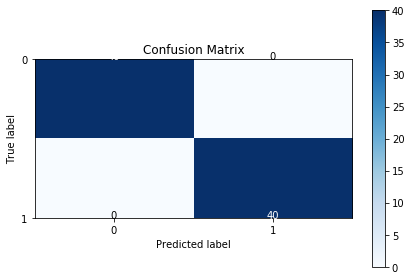

In [22]:
cm = confusion_matrix(test_generator.classes, y_pred)
util.plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


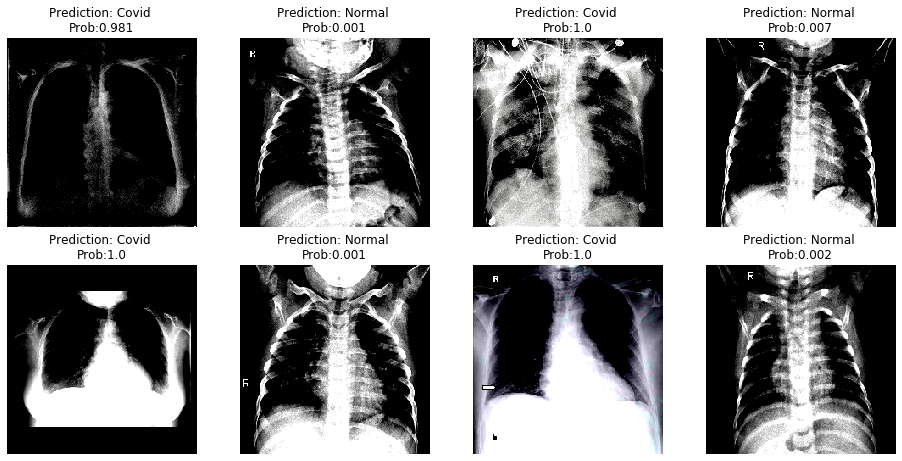

In [23]:
x, y = test_generator.__getitem__(0)

plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, np.around(pred[:8].flatten(),3))):
    plt.subplot(4, 4, i+1)
    if label >= 0.5:
        plt.title('Prediction: Covid \n' +'Prob:'+ str(label))
    else:
        plt.title('Prediction: Normal \n' +'Prob:'+ str(label))
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

## VGG16



Next, we will use a pre-trained VGG16 model which we can load directly from Keras and then add two layers on top of it:

A GlobalAveragePooling2D layer to get the average of the last convolution layers from VGG16.
A Dense layer with sigmoid activation to get the prediction logits for each of our classes.

In [24]:
# Load a VGG model without the top layer which consists of fully connected layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Do not train existing weights, they already derive from 'imagenet'
for layer in vgg.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg.output)
prediction = Dense(len(labels), activation="sigmoid")(x)


model_vgg = Model(inputs=vgg.input, outputs=prediction)

In [25]:
# Configure the model for training
model_vgg.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
print(model_vgg.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [27]:
history_vgg = model_vgg.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(valid_generator), 
                              epochs = 20,
                              callbacks=[es],
                              class_weight = class_weights)

Epoch 1/20
33/33 [==============================] - 56s 2s/step - loss: 0.6530 - accuracy: 0.6000 - val_loss: 0.5867 - val_accuracy: 0.8250
Epoch 2/20
33/33 [==============================] - 57s 2s/step - loss: 0.5628 - accuracy: 0.9077 - val_loss: 0.5002 - val_accuracy: 0.9750
Epoch 3/20
33/33 [==============================] - 58s 2s/step - loss: 0.4754 - accuracy: 0.9731 - val_loss: 0.4302 - val_accuracy: 1.0000
Epoch 4/20
33/33 [==============================] - 56s 2s/step - loss: 0.4170 - accuracy: 0.9846 - val_loss: 0.3750 - val_accuracy: 1.0000
Epoch 5/20
33/33 [==============================] - 59s 2s/step - loss: 0.3626 - accuracy: 0.9923 - val_loss: 0.3293 - val_accuracy: 1.0000
Epoch 6/20
33/33 [==============================] - 65s 2s/step - loss: 0.3344 - accuracy: 0.9808 - val_loss: 0.2911 - val_accuracy: 1.0000
Epoch 7/20
33/33 [==============================] - 54s 2s/step - loss: 0.2949 - accuracy: 0.9808 - val_loss: 0.2600 - val_accuracy: 1.0000
Epoch 8/20
33/33 [==

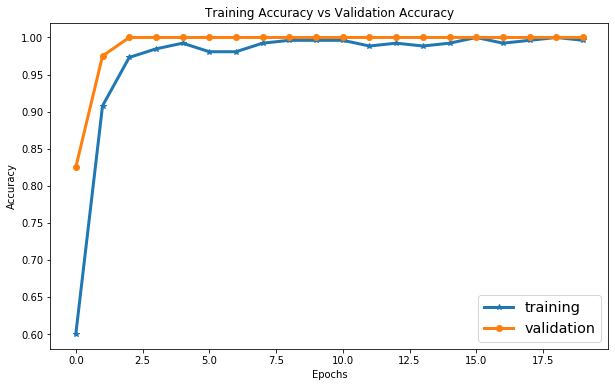

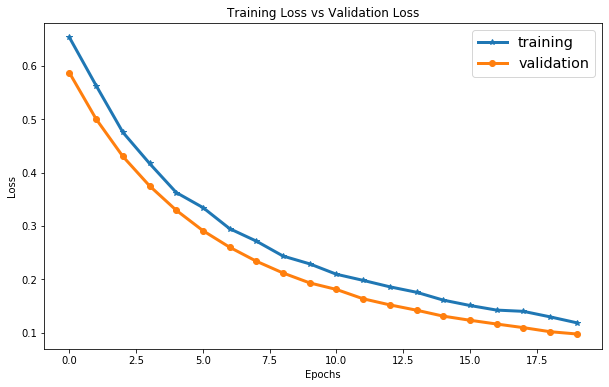

In [28]:
util.visualize_training(history_vgg)

## Prediction and Evaluation
Now we have a model, let's evaluate it using our test set. WE can conveniently use the predict_generator fuction to generate the predctions for the images in our test set

In [29]:
loss, acc = model_vgg.evaluate_generator(test_generator,
                                     steps= len(test_generator),
                                     verbose=1)
print('loss: ', loss, 'accuracy: ', acc)

10/10 [==============================] - 12s 1s/step - loss: 0.0794 - accuracy: 1.0000
loss:  0.07943642139434814 accuracy:  1.0


In [30]:
test_generator.reset()
pred_test = model_vgg.predict_generator(test_generator, len(test_generator), verbose=1)
y_pred2 = []
threshold = 0.5
for i in pred_test:
    if i >= threshold:
        y_pred2.append(1)
    else:  y_pred2.append(0)


10/10 [==============================] - 12s 1s/step


In [31]:
test_generator.reset()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred2, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



Confusion matrix, without normalization
[[40  0]
 [ 0 40]]


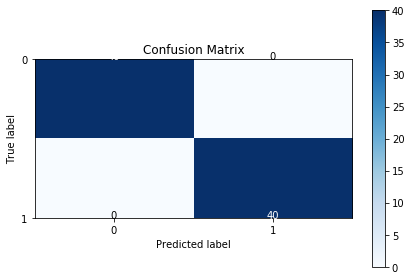

In [32]:
cm2 = confusion_matrix(test_generator.classes, y_pred2)
util.plot_confusion_matrix(cm=cm2, classes=target_names, title='Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


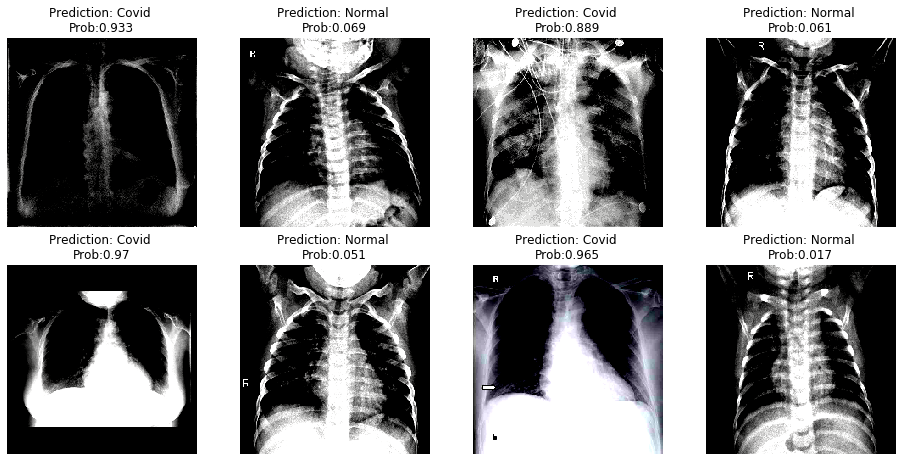

In [33]:
x, y = test_generator.__getitem__(0)

plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, np.around(pred_test[:8].flatten(),3))):
    plt.subplot(4, 4, i+1)
    if label >= 0.5:
        plt.title('Prediction: Covid \n' +'Prob:'+ str(label))
    else:
        plt.title('Prediction: Normal \n' +'Prob:'+ str(label))
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

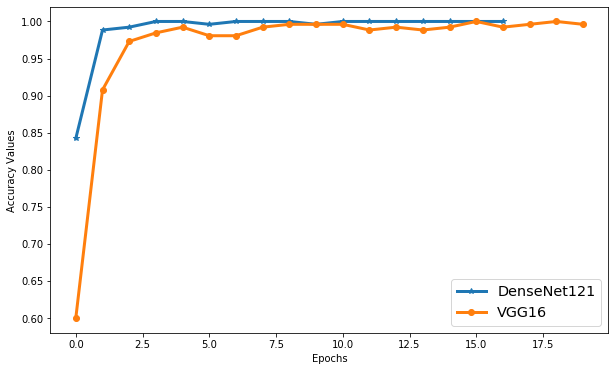

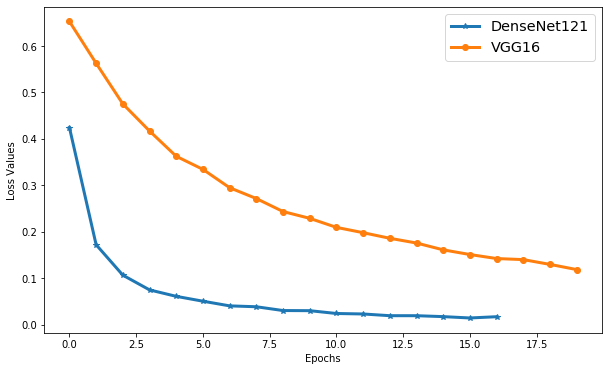

In [34]:
util.visualize_training_compare(history, history_vgg)